In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '33-resnet152'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_PATH = f'{COLAB_BASE_PATH}Submissions/{MODEL_NAME}.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [5]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [6]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.5.146.130:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Model parameters

In [7]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 256,
  "EPOCHS": 30,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "BASE_MODEL": 'resnet152',
  "BASE_MODEL_WEIGHTS": 'imagenet11k',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'resnet152',
 'BASE_MODEL_WEIGHTS': 'imagenet11k',
 'BATCH_SIZE': 256,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 30,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'WIDTH': 256}

# Load data

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH ='gs://kds-e12fcdd8602eaeb3e7343f4b322f78239cfa17e4bf5db65058b851ad' # KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.000297 to 1.16e-05


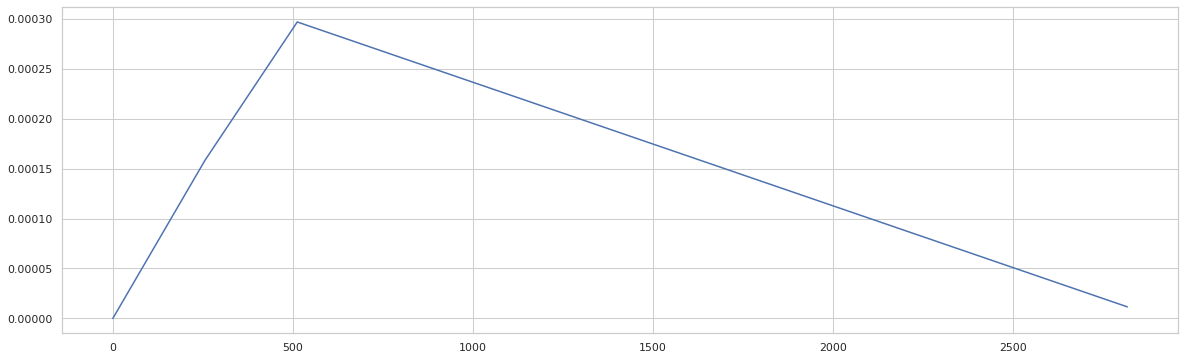

In [11]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 25000 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [12]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    BaseModel, preprocess_input = Classifiers.get(config['BASE_MODEL'])
    base_model = BaseModel(input_shape=input_shape, 
                           weights=config['BASE_MODEL_WEIGHTS'], 
                           include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [13]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(len(k_fold)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        train_size = count_data_items(train_filenames)

        step_size = train_size // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=True, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                     total_steps=total_steps, warmup_steps=warmup_steps, 
                                                     hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                     lr_max=lr_max, lr_min=lr_min)

            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=step_size,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        history_list.append(history)

        # Make predictions
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
97/97 - 75s - auc: 0.6336 - loss: 0.2233 - val_auc: 0.5345 - val_loss: 0.2272
Epoch 2/30
97/97 - 42s - auc: 0.7982 - loss: 0.1707 - val_auc: 0.4611 - val_loss: 0.6670
Epoch 3/30
97/97 - 52s - auc: 0.8173 - loss: 0.1688 - val_auc: 0.5144 - val_loss: 0.1933
Epoch 4/30
97/97 - 42s - auc: 0.8382 - loss: 0.1683 - val_auc: 0.3622 - val_loss: 0.7695
Epoch 5/30
97/97 - 42s - auc: 0.8460 - loss: 0.1662 - val_auc: 0.5048 - val_loss: 0.2041
Epoch 6/30
97/97 - 43s - auc: 0.8366 - loss: 0.1672 - val_auc: 0.5201 - val_loss: 0.1949
Epoch 7/30
97/97 - 45s - auc: 0.8726 - loss: 0.1645 - val_auc: 0.5000 - val_loss: 0.2373
Epoch 8/30
97/97 - 42s - auc: 0.8757 - loss: 0.1645 - val_auc: 0.6563 - val_loss: 0.2203
Epoch 9/30
97/97 - 54s - auc: 0.8665 - loss: 0.1645 - val_auc: 0.7018 - val_loss: 0.1719
Epoch 10/30
97/97 - 53s - auc: 0.8851 - loss: 0.1630 - val_auc: 0.7863 - val_loss: 0.1676
Epoch 11/30
97/97 - 42s - auc: 0.8838 - loss: 0.1632 - val_auc: 0.8087 - val_loss: 0.1682
Epoch 12/30
97/97 -

INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
105/105 - 77s - auc: 0.6444 - loss: 0.2375 - val_auc: 0.4817 - val_loss: 2.0711
Epoch 2/30
105/105 - 55s - auc: 0.8166 - loss: 0.1675 - val_auc: 0.5017 - val_loss: 0.1858
Epoch 3/30
105/105 - 44s - auc: 0.8270 - loss: 0.1672 - val_auc: 0.5000 - val_loss: 0.2598
Epoch 4/30
105/105 - 55s - auc: 0.8238 - loss: 0.1681 - val_auc: 0.4692 - val_loss: 0.1743
Epoch 5/30
105/105 - 46s - auc: 0.8443 - loss: 0.1670 - val_auc: 0.4909 - val_loss: 0.1874
Epoch 6/30
105/105 - 54s - auc: 0.8730 - loss: 0.1652 - val_auc: 0.5754 - val_loss: 0.1732
Epoch 7/30
105/105 - 45s - auc: 0.8696 - loss: 0.1643 - val_auc: 0.5065 - val_loss: 0.1964
Epoch 8/30
105/105 - 54s - auc: 0.8752 - loss: 0.1646 - val_auc: 0.7000 - val_loss: 0.1720
Epoch 9/30
105/105 - 55s - auc: 0.8889 - loss: 0.1628 - val_auc: 0.7262 - val_loss: 0.1712
Epoch 10/30
105/105 - 54s - auc: 0.8847 - loss: 0.1629 - val_auc: 0.8595 - val_loss: 0.1704
Epoch 11/30
105/105 - 44s - auc: 0.8879 - loss: 0.1618 - val_auc: 0.7867 - val_loss: 0.19

INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
105/105 - 76s - auc: 0.6073 - loss: 0.3990 - val_auc: 0.4852 - val_loss: 3.1051
Epoch 2/30
105/105 - 54s - auc: 0.8028 - loss: 0.1700 - val_auc: 0.4926 - val_loss: 0.3523
Epoch 3/30
105/105 - 54s - auc: 0.8350 - loss: 0.1665 - val_auc: 0.6025 - val_loss: 0.1891
Epoch 4/30
105/105 - 44s - auc: 0.8501 - loss: 0.1660 - val_auc: 0.4914 - val_loss: 0.2114
Epoch 5/30
105/105 - 44s - auc: 0.8473 - loss: 0.1651 - val_auc: 0.4218 - val_loss: 0.2005
Epoch 6/30
105/105 - 44s - auc: 0.8736 - loss: 0.1642 - val_auc: 0.5227 - val_loss: 0.2063
Epoch 7/30
105/105 - 44s - auc: 0.8677 - loss: 0.1638 - val_auc: 0.6740 - val_loss: 0.2058
Epoch 8/30
105/105 - 44s - auc: 0.8845 - loss: 0.1625 - val_auc: 0.6555 - val_loss: 0.2069
Epoch 9/30
105/105 - 44s - auc: 0.8858 - loss: 0.1620 - val_auc: 0.5070 - val_loss: 0.2155
Epoch 10/30
105/105 - 44s - auc: 0.8950 - loss: 0.1614 - val_auc: 0.7638 - val_loss: 0.2247
Epoch 11/30
105/105 - 44s - auc: 0.9077 - loss: 0.1590 - val_auc: 0.8265 - val_loss: 0.19

INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
105/105 - 76s - auc: 0.5974 - loss: 0.4430 - val_auc: 0.5952 - val_loss: 3.4529
Epoch 2/30
105/105 - 54s - auc: 0.8170 - loss: 0.1689 - val_auc: 0.5413 - val_loss: 2.6039
Epoch 3/30
105/105 - 54s - auc: 0.8395 - loss: 0.1670 - val_auc: 0.6392 - val_loss: 0.1757
Epoch 4/30
105/105 - 44s - auc: 0.8418 - loss: 0.1659 - val_auc: 0.6006 - val_loss: 0.1999
Epoch 5/30
105/105 - 44s - auc: 0.8497 - loss: 0.1651 - val_auc: 0.5857 - val_loss: 0.2226
Epoch 6/30
105/105 - 44s - auc: 0.8519 - loss: 0.1659 - val_auc: 0.4340 - val_loss: 0.2106
Epoch 7/30
105/105 - 44s - auc: 0.8852 - loss: 0.1627 - val_auc: 0.6165 - val_loss: 0.2208
Epoch 8/30
105/105 - 44s - auc: 0.8815 - loss: 0.1623 - val_auc: 0.6749 - val_loss: 0.2296
Epoch 9/30
105/105 - 44s - auc: 0.8803 - loss: 0.1629 - val_auc: 0.7196 - val_loss: 0.1925
Epoch 10/30
105/105 - 44s - auc: 0.8956 - loss: 0.1610 - val_auc: 0.8175 - val_loss: 0.2001
Epoch 11/30
105/105 - 55s - auc: 0.8952 - loss: 0.1592 - val_auc: 0.7956 - val_loss: 0.16

INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
105/105 - 76s - auc: 0.6645 - loss: 0.2102 - val_auc: 0.4293 - val_loss: 0.2112
Epoch 2/30
105/105 - 54s - auc: 0.8071 - loss: 0.1694 - val_auc: 0.4959 - val_loss: 0.1869
Epoch 3/30
105/105 - 54s - auc: 0.8443 - loss: 0.1666 - val_auc: 0.4930 - val_loss: 0.1851
Epoch 4/30
105/105 - 55s - auc: 0.8515 - loss: 0.1657 - val_auc: 0.4583 - val_loss: 0.1745
Epoch 5/30
105/105 - 44s - auc: 0.8315 - loss: 0.1677 - val_auc: 0.5000 - val_loss: 10.1142
Epoch 6/30
105/105 - 44s - auc: 0.8533 - loss: 0.1662 - val_auc: 0.5092 - val_loss: 0.2349
Epoch 7/30
105/105 - 44s - auc: 0.8679 - loss: 0.1660 - val_auc: 0.7004 - val_loss: 0.1840
Epoch 8/30
105/105 - 44s - auc: 0.8759 - loss: 0.1622 - val_auc: 0.6943 - val_loss: 0.2242
Epoch 9/30
105/105 - 44s - auc: 0.8754 - loss: 0.1653 - val_auc: 0.7837 - val_loss: 0.1923
Epoch 10/30
105/105 - 44s - auc: 0.8809 - loss: 0.1630 - val_auc: 0.8490 - val_loss: 0.1816
Epoch 11/30
105/105 - 45s - auc: 0.8784 - loss: 0.1630 - val_auc: 0.8795 - val_loss: 0.2

## Model loss graph

Fold: 1


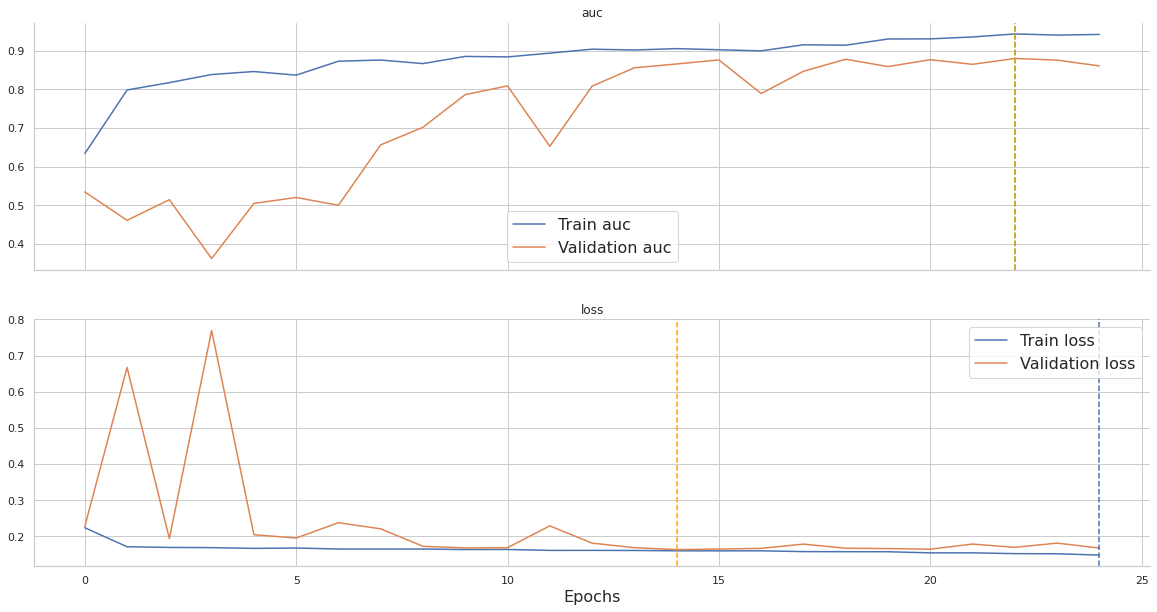

Fold: 2


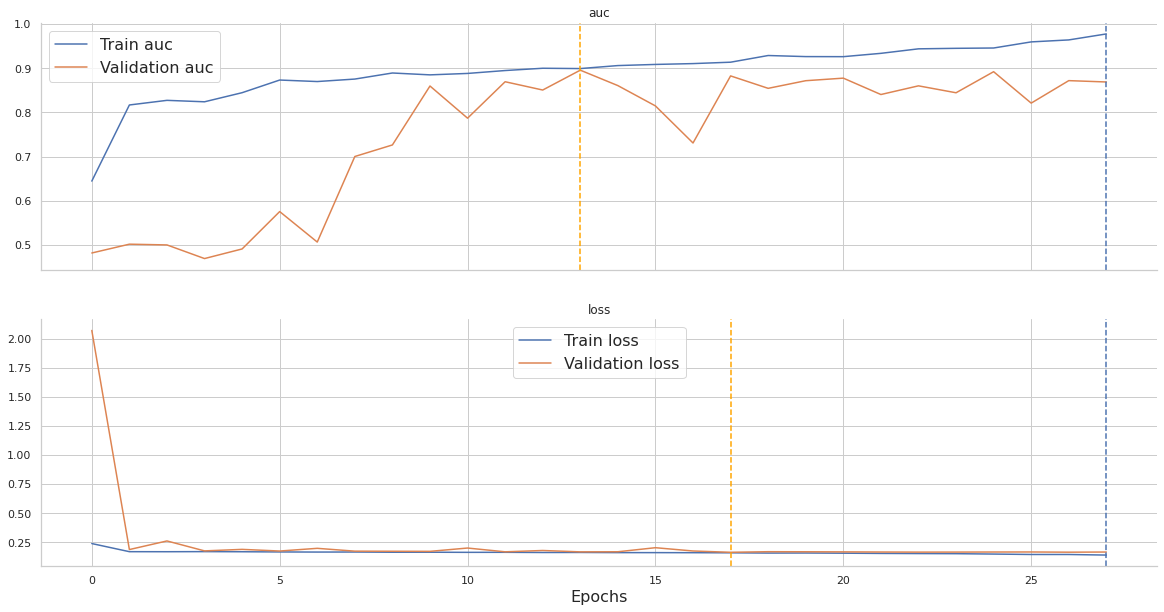

Fold: 3


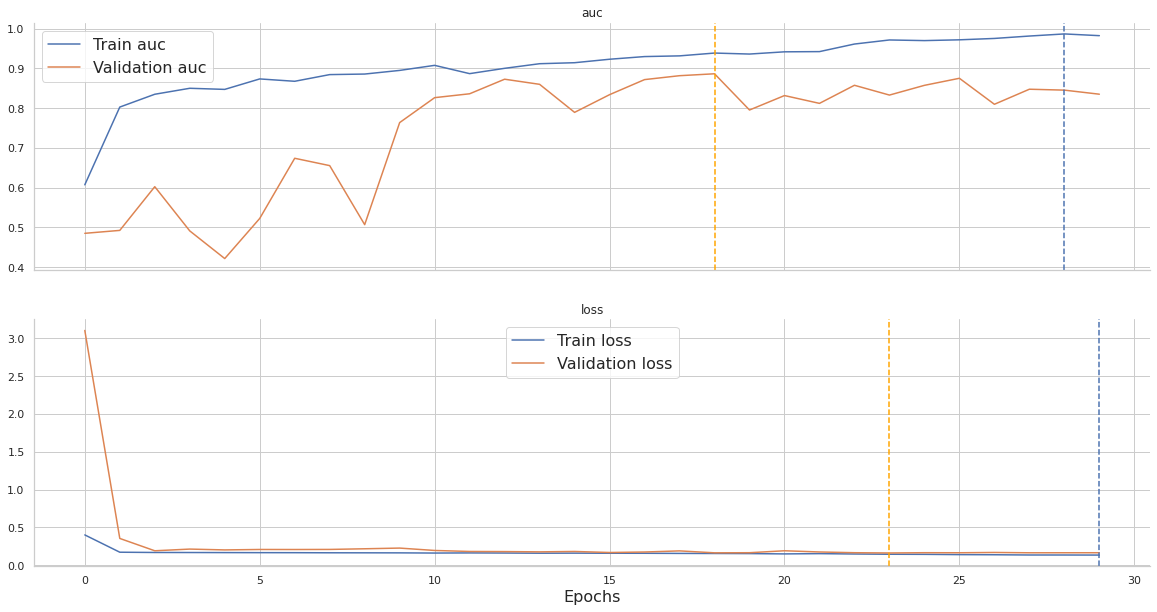

Fold: 4


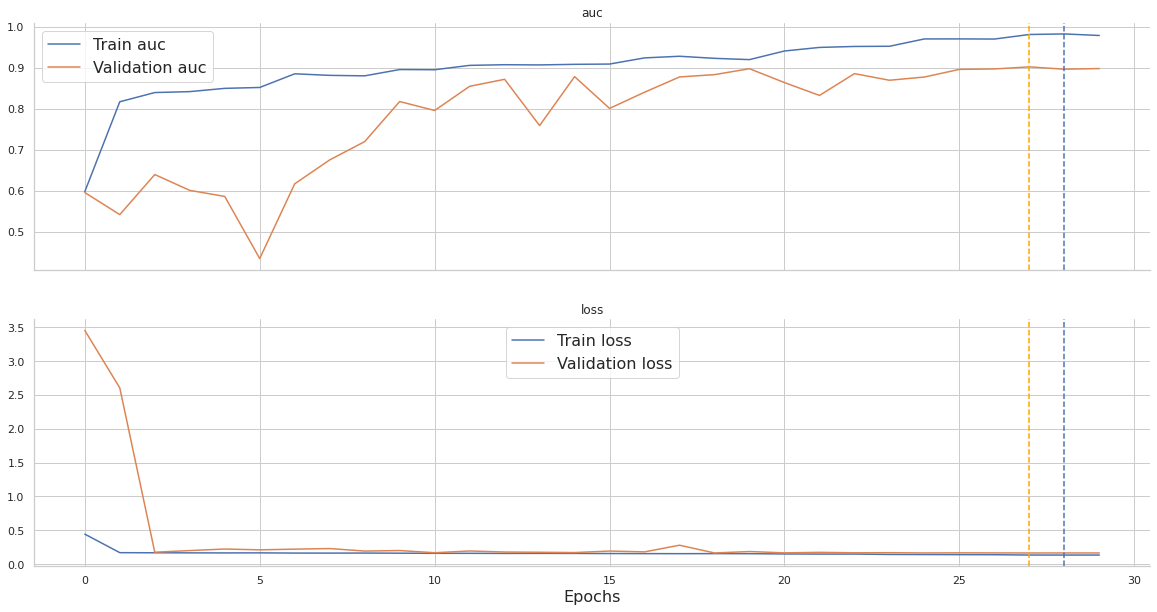

Fold: 5


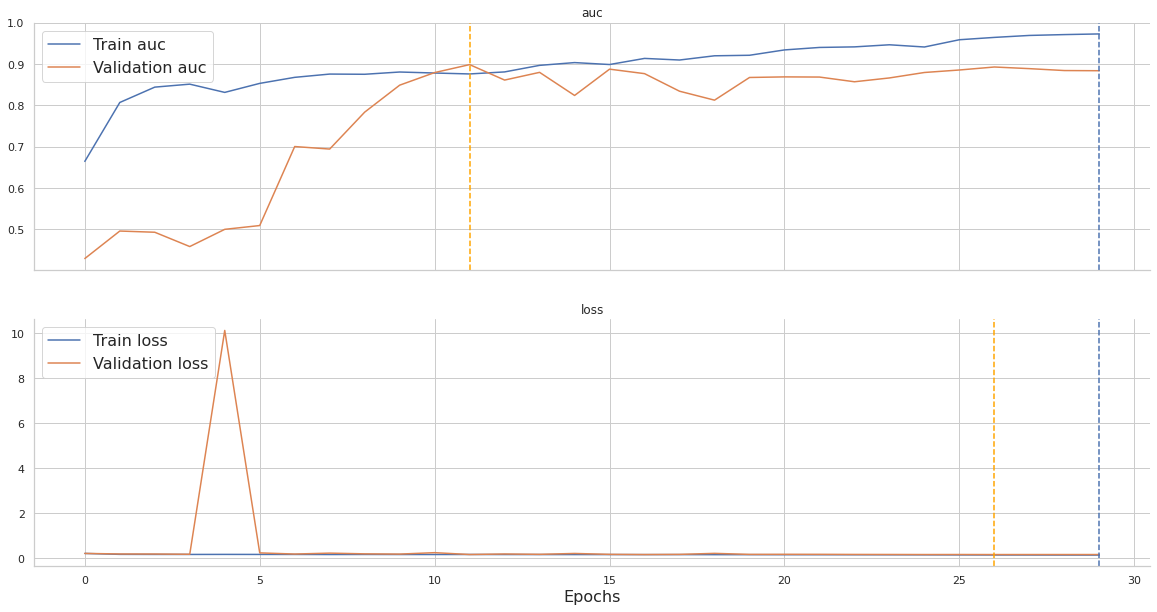

In [14]:
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

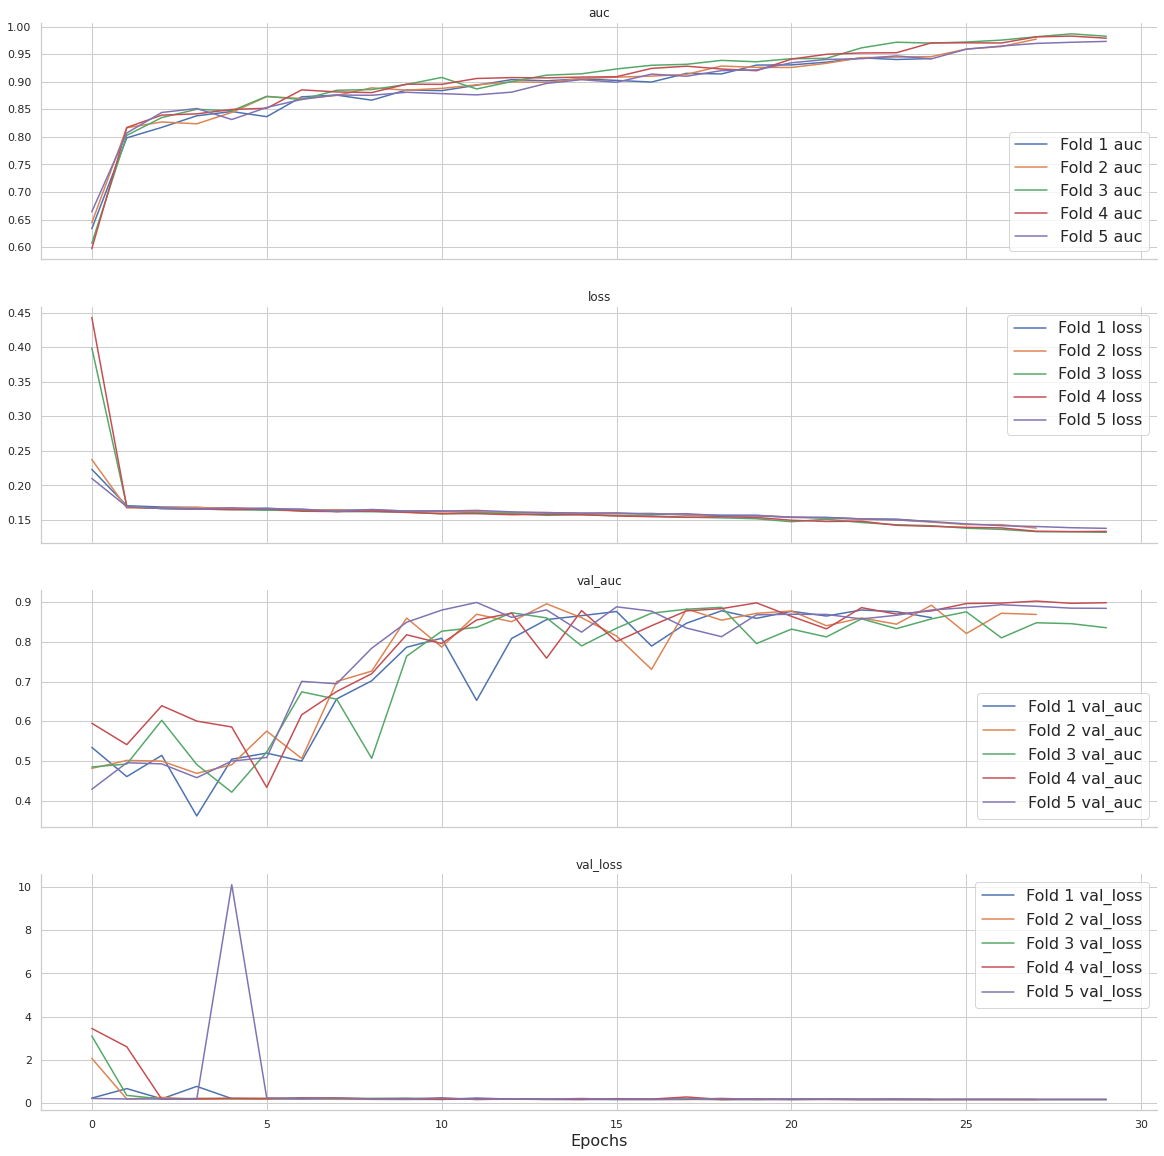

In [15]:
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [16]:
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.974451,0.877713,0.096738,0.947804,0.867955,0.945445,0.886133,0.997415,0.848440,0.992541,0.900000,0.989049,0.886036
Accuracy,0.991617,0.982064,0.009553,0.984985,0.982134,0.984914,0.981651,0.996916,0.982456,0.996806,0.981622,0.994464,0.982456
Precision,0.913572,0.407877,0.505695,0.773438,0.370370,0.904762,0.166667,0.966346,0.535714,0.975369,0.478261,0.947945,0.488372
Recall,0.560638,0.147275,0.413364,0.223476,0.070922,0.160338,0.009091,0.853503,0.265487,0.838983,0.196429,0.726891,0.194444
F1-score,0.650094,0.209589,0.440504,0.346760,0.119048,0.272401,0.017241,0.906426,0.355030,0.902050,0.278481,0.822830,0.278146
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [17]:
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.974451,0.877713,0.096738,0.947804,0.867955,0.945445,0.886133,0.997415,0.848440,0.992541,0.900000,0.989049,0.886036
male,0.974947,0.880848,0.094099,0.944906,0.877233,0.948433,0.876987,0.996999,0.861994,0.993959,0.911934,0.990435,0.876093
female,0.972897,0.868213,0.104684,0.950425,0.851476,0.940758,0.893419,0.997989,0.815565,0.989465,0.883414,0.985850,0.897190
head/neck,0.972854,0.835186,0.137668,0.922842,0.884419,0.947683,0.802260,0.999378,0.865015,0.997339,0.762702,0.997025,0.861535
upper extremity,0.975218,0.876471,0.098748,0.939518,0.856724,0.957081,0.877389,0.997475,0.852183,0.989082,0.908793,0.992936,0.887264
lower extremity,0.966799,0.836235,0.130563,0.943219,0.803857,0.930518,0.854315,0.995106,0.793636,0.987190,0.898459,0.977960,0.830910
torso,0.978034,0.911323,0.066710,0.959119,0.899703,0.947566,0.930808,0.998204,0.873461,0.994611,0.947190,0.990669,0.905454
0 <= age < 26,0.959174,0.770529,0.188644,0.920092,0.901399,0.918021,0.850928,0.987611,0.700839,0.997211,0.753275,0.972932,0.646205
26 <= age < 40,0.967243,0.843492,0.123751,0.944593,0.865600,0.924513,0.815560,0.999152,0.721468,0.978811,0.959302,0.989149,0.855532


# Confusion matrix

Fold: 1


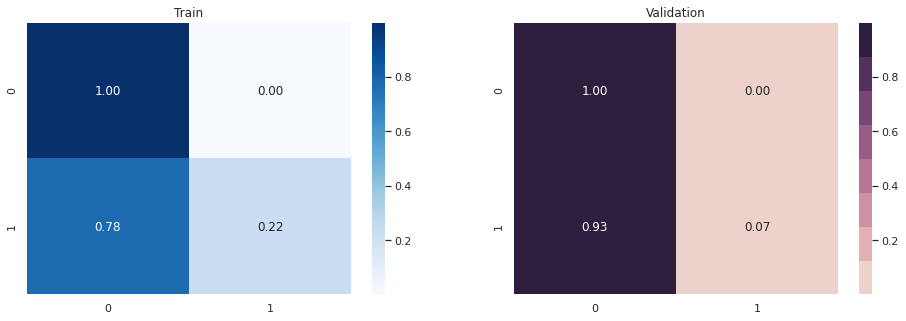

Fold: 2


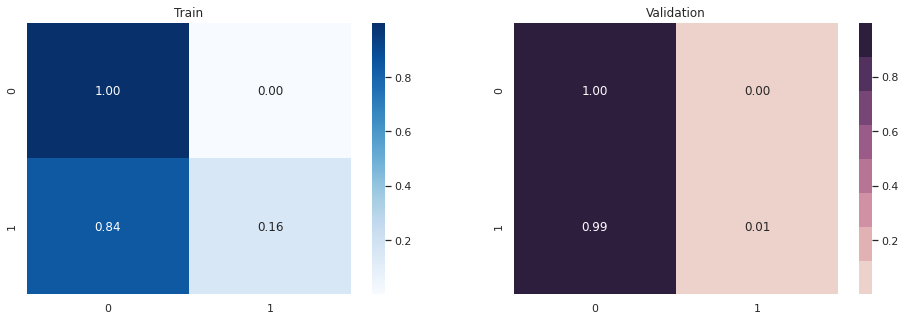

Fold: 3


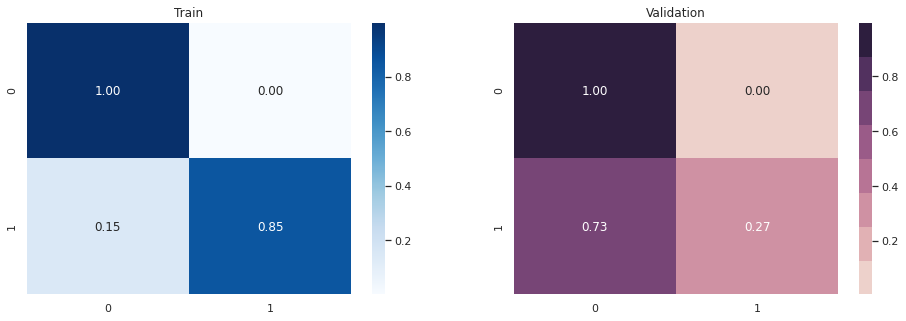

Fold: 4


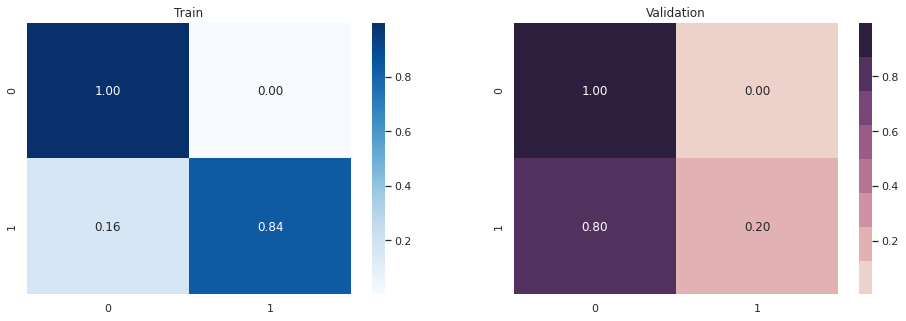

Fold: 5


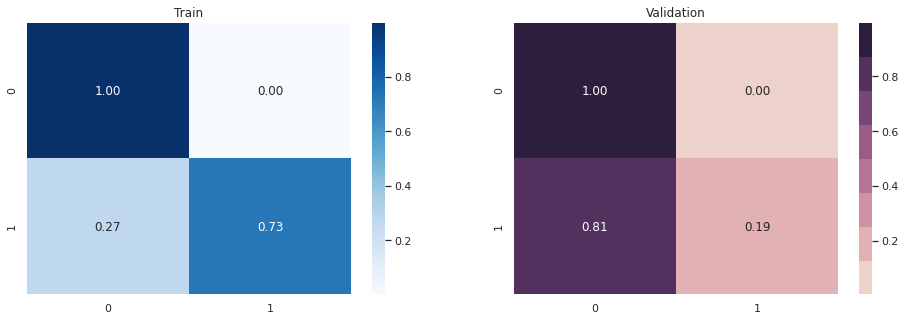

In [18]:
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [19]:
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.024544,0.031770,0.022432,0.018840,0.022495,0.027183
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.025837,0.023384,0.024265,0.027394,0.025231,0.028913
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.026067,0.030951,0.025334,0.023255,0.024157,0.026640
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.030931,0.028982,0.028825,0.026768,0.038611,0.031468
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.024976,0.021188,0.022576,0.025186,0.025446,0.030485
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.025902,0.027561,0.022779,0.025170,0.026689,0.027311
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.034978,0.037005,0.041566,0.035568,0.027222,0.033530
7,ISIC_0075663,female,35.0,torso,unknown,0,0.022699,0.023001,0.028856,0.017127,0.018791,0.025719
8,ISIC_0075914,male,30.0,torso,unknown,0,0.027930,0.028481,0.022522,0.024255,0.037705,0.026686
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.026302,0.026265,0.029703,0.028770,0.021584,0.025186


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.525852,0.023556,0.180152,0.991075,0.981909,0.452568
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.619621,0.094670,0.269475,0.993114,0.763538,0.977308
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.418753,0.110021,0.068606,0.027234,0.992897,0.895007
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.151545,0.091842,0.104549,0.230228,0.057226,0.273881
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.603212,0.069357,0.174381,0.913683,0.989785,0.868855
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.498182,0.335937,0.161180,0.947234,0.085375,0.961184
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.325181,0.148044,0.058904,0.264422,0.996749,0.157787
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.605354,0.136035,0.046482,0.943147,0.917413,0.983693
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.488222,0.196099,0.078746,0.869788,0.975845,0.320630
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.407197,0.258403,0.054001,0.026734,0.991942,0.704908


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.525852,0.023556,0.180152,0.991075,0.981909,0.452568
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.619621,0.094670,0.269475,0.993114,0.763538,0.977308
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.603212,0.069357,0.174381,0.913683,0.989785,0.868855
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.605354,0.136035,0.046482,0.943147,0.917413,0.983693
580,ISIC_0280912,male,70.0,torso,melanoma,1,0.589840,0.024223,0.052446,0.997497,0.972535,0.902499
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.860337,0.746319,0.620779,0.940354,0.995755,0.998476
826,ISIC_0351666,male,80.0,head/neck,melanoma,1,0.633539,0.133232,0.117554,0.933790,0.991162,0.991954
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.552958,0.315582,0.210148,0.653665,0.954912,0.630484
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.829461,0.694090,0.480570,0.998237,0.974420,0.999985
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.844386,0.771078,0.485541,0.993462,0.983339,0.988511


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 316
Train positive correct predictions: 316


# Make predictions

In [20]:
model_path_list = glob.glob(MODEL_BASE_PATH + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

5 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/33-resnet152/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/33-resnet152/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/33-resnet152/model_fold_3.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/33-resnet152/model_fold_4.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/33-resnet152/model_fold_5.h5


In [21]:
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset) / n_models


image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/33-resnet152/model_fold_1.h5


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/33-resnet152/model_fold_2.h5


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/33-resnet152/model_fold_3.h5


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/33-resnet152/model_fold_4.h5


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.146.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/33-resnet152/model_fold_5.h5


# Visualize test predictions

In [22]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge','target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 38|10944
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0052060,male,70.0,NaN,0.036510
1,ISIC_0052349,male,40.0,lower extremity,0.026432
2,ISIC_0058510,female,55.0,torso,0.025526
3,ISIC_0073313,female,50.0,torso,0.029549
4,ISIC_0073502,female,45.0,lower extremity,0.025071
5,ISIC_0074618,male,50.0,lower extremity,0.030873
6,ISIC_0076801,male,45.0,upper extremity,0.028886
7,ISIC_0077586,male,50.0,lower extremity,0.037088
8,ISIC_0082004,female,45.0,torso,0.039707
9,ISIC_0082785,male,65.0,lower extremity,0.030988


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
24,ISIC_0112420,female,65.0,torso,0.527250
403,ISIC_0481105,male,80.0,torso,0.802886
522,ISIC_0585534,male,70.0,head/neck,0.667350
1069,ISIC_1030252,female,50.0,head/neck,0.529737
1408,ISIC_1364884,female,35.0,upper extremity,0.733654
1485,ISIC_1429763,male,45.0,head/neck,0.582568
1525,ISIC_1460169,male,55.0,head/neck,0.591053
1677,ISIC_1593714,female,50.0,lower extremity,0.675085
1764,ISIC_1670692,male,50.0,torso,0.690987
2214,ISIC_2098553,male,55.0,torso,0.590745


# Test set predictions

In [23]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission.to_csv(SUBMISSION_PATH, index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
0,ISIC_0052060,0.036510
1,ISIC_0052349,0.026432
2,ISIC_0058510,0.025526
3,ISIC_0073313,0.029549
4,ISIC_0073502,0.025071
5,ISIC_0074618,0.030873
6,ISIC_0076801,0.028886
7,ISIC_0077586,0.037088
8,ISIC_0082004,0.039707
9,ISIC_0082785,0.030988


,target
count,10982.000000
mean,0.044593
std,0.053741
min,0.016401
25%,0.027475
50%,0.030319
75%,0.039998
max,0.897895
